## Gottesacker SWMM model
Based on Zhao Chen's Gottesacker model.
***
**Functions:**
<br>- Writes SWMM project.inp files using a template (template.inp) - searches for placeholder strings in the template and replaces them with data from a pandas dataframe. Dataframes can be created manually, or loaded from .csv files.
<br>- Run SWMM using the specified project.inp file
<br>
<br>
**Goals:**
<br>- Import results from project.rpt file as pandas dataframes
***
**Files needed:**
<br>- template.inp
<br>- swmm5.exe
<br>- swmm5.dll
<br>
<br>
**Packages needed:**
<br>- pandas
<br>- numpy
<br>- subprocess
<br>- swmmtoolbox

**Notes:**
<br>- template.inp files must not have any commas in them (otherwise the importer thinks they are column breaks)
<br>- placeholders in template.inp files must not have any other characters (even spaces) in the same line

In [1]:
import pandas as pd
import numpy as np
import subprocess as sb
import swmmpy as sp
import importlib
from swmmtoolbox import swmmtoolbox as st
import matplotlib.pyplot as plt
#Embed matplotlib figures into notebooks:
%matplotlib inline

In [2]:
importlib.reload(sp)

<module 'swmmpy' from 'C:\\Users\\Chloe\\Documents\\GitHub\\swmm\\swmmpy_module\\swmmpy.py'>

In [92]:
#File structure and naming:

exe =               'swmm5.exe'                                             #filename for swmm executable
template_filename = 'template2.inp'                                          #filename for template .inp file to import
projectname =       'gott2'                                             #name to use when writing new .inp file, and .pt and .out files

inputfile =          projectname+'.inp'                                     #filename to write new .inp file to
reportfile =         projectname+'.rpt'                                     #filename to write .rpt file to
outputfile =         projectname+'.out'                                     #filename to write .out file to

data_filenames =    ['junctions.csv', 'conduits.csv', 'coordinates.csv']    #csv filenames with data to insert into the .inp file
placeholders =      ['junctions', 'conduits', 'coordinates']                #placeholder strings to search for and replace with data


In [95]:
#Write a SWMM input file using a template and data csv files:
sp.write_input(inputfile, placeholders, data_filenames, template_filename=template_filename)

In [94]:
#Debugging section
run = True
if run == True:
    #Manual functions:
    template = pd.read_csv(template_filename, header=None, skip_blank_lines=False)  #import template .inp file to dataframe
    print(template.iloc[50:55])


    for i in range(len(placeholders)):                                          #loop over list of placeholders
        data = sp.import_data(data_filenames[i])                                   #import data to insert from csv
        template = sp.insert_data(template,  placeholders[i], data)                #replace placeholder string with data
    print(template.iloc[50:55])

    template.to_csv(inputfile, header=False, index=False, quoting=3)                       #write dataframe to .inp text file with specified name
    temp = pd.read_csv(inputfile, header=None, skip_blank_lines=False)  #import template .inp file to dataframe
    print(temp.iloc[50:55])
        
    #Run SWMM with new input file:
    p = sb.Popen([exe, inputfile, reportfile, outputfile], stdout=sb.PIPE, universal_newlines=True)          #run SWMM (and report process output)
    for line in p.stdout:          #for each line of process output
        if 'hour' not in line:     #if the line doesn't include the string 'hour' (to avoid a huge mass of text for each timestep)
            print(line)

                                                    0
50  2                VOLUME    1:00   1.0      TIM...
51  3                VOLUME    1:00   1.0      TIM...
52  4                VOLUME    1:00   1.0      TIM...
53  5                VOLUME    1:00   1.0      TIM...
54  6                VOLUME    1:00   1.0      TIM...
                                                    0
50  2                VOLUME    1:00   1.0      TIM...
51  3                VOLUME    1:00   1.0      TIM...
52  4                VOLUME    1:00   1.0      TIM...
53  5                VOLUME    1:00   1.0      TIM...
54  6                VOLUME    1:00   1.0      TIM...
                                                    0
50  2                VOLUME    1:00   1.0      TIM...
51  3                VOLUME    1:00   1.0      TIM...
52  4                VOLUME    1:00   1.0      TIM...
53  5                VOLUME    1:00   1.0      TIM...
54  6                VOLUME    1:00   1.0      TIM...


 o  Retrieving project dat

In [11]:
#Run SWMM with new .inp and generate .rpt and .out files   
sp.run(inputfile, reportfile, outputfile)



 o  Retrieving project data

... EPA-SWMM 5.1 (Build 5.1.13)





... EPA-SWMM completed in 51.00 seconds. There are warnings.



Available outflow nodes:	 ['3001' '3002' '3003' '3005']
Available data types:		 ['Depth_above_invert' 'Hydraulic_head' 'Volume_stored_ponded'
 'Lateral_inflow' 'Total_inflow' 'Flow_lost_flooding']


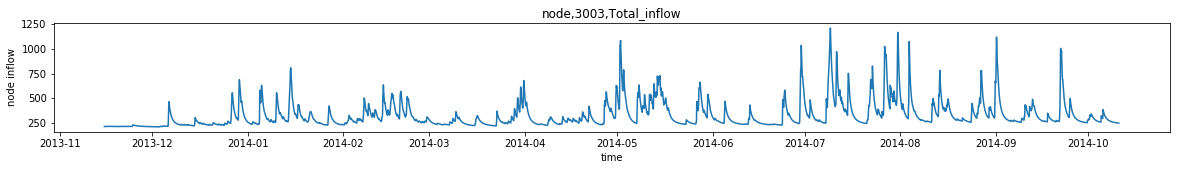

In [91]:
#Read outputs:

#Report file:
report = pd.read_table(reportfile, header=None)  #read report file into dataframe

#Output file:
node_info = st.catalog('zhao_original.out', itemtype='node')             #get node info (i.e. what data is available)
node_info = pd.DataFrame(nodes, columns=['itemtype','name','datatype'])  #convert to dataframe
nodenames = node_info.name.unique()
datatypes = node_info.datatype.unique()
print('Available outflow nodes:\t', nodenames)  #display available nodes & data types
print('Available data types:\t\t',    datatypes)
label = '{},{},{}'.format(node_info.itemtype[0], nodenames[2], datatypes[4])  #create label to identify desired data series
nodeInflow = st.extract('zhao_original.out', label)   #get node data

#Plot:
plt.figure(figsize=(20,2))
plt.plot(nodeInflow.iloc[10:])  #cut off first few data points where head=0
plt.ylabel('node inflow')
plt.xlabel('time')
plt.title(label)